# AI Text Cassification with PyTorch + LSTM

**Taavi Kalaluka, 2024**

## Introduction

The idea for this project came from a deep interest in AI and its effect on society. Ever since the advent of ChatGPT, I've been wondering how it will impact our society. I have a little sister in 7th grade and I thought about how different school must be for her compared to how it was for me, since ChatGPT excels at simple essays. Surely many students in middle school would be tempted to use ChatGPT to write their essays for English class, when back in the days we had to do everything with our own brains.

Then I remembered hearing about an AI detection tool on Instagram, where an American college student had created a system for identifying AI text. I was sceptical at how well such a tool would work. How could you possibly detect AI in text? Human text is so complex, and humans have very different writing styles. I hypothesized that he must have used AI to detect AI, fighting fire with fire. I was motivated to try something similar, to see how well it would work out.

I've been tinkering with AI for quite a long time now, having completed Stanford Online's Machine Learning Specialization in early 2023 and messed around with custom versions of different LLMs in my free time. I initially thought that I would have to use a pre-trained language model for this project, and train a custom version to detect AI. However, I also figured that it would be an excellent learning experience to implement my own model from scratch, even though the results might not be as good.

For this project, I decided to use PyTorch since we used Tensorflow in this course and I thought it would be a good opportunity to use another deep learning framework. Initially, it was quite complicated to make the switch, as PyTorch requires you to do many things manually which Tensorflow does automatically out of the box (thanks to Keras for making it so easy). Even though PyTorch is a lot more code, it has the advantage of allowing for more flexbility and customization. Overall, I'm a big fan of PyTorch!

## Implementation

### Imports

In [22]:
# Pandas for data loading
import pandas as pd

# Tqdm for
from tqdm import tqdm

# Seaborn and matplotlib for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch for model building
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# BERT Tokenizer from the transformers library
from transformers import BertTokenizer

# Scikit-learn for model evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Pickle for saving and loading variables
import pickle

### Data loading and initial analysis

I used Google Colab for running this notebook, because of the free T4 GPUs they allow you to use. This made training significantly faster, and allowed me to test many different versions of the model without frying my computer. However, for everything apart from the training of the model I still used my computer, and that's why I have two different ways of loading the data below, depending on whether I'm using my computer or Colab.

In [2]:
# Colab stuff

from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/AI classification/data/AI_Human.csv')
df.head()

Mounted at /content/drive


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [3]:
# df = pd.read_csv('data/AI_Human.csv')
# print(f'Number of rows: {len(df)}')
# df.head()

The dataset contains 487,235 rows, where each row is an example. The column `text` contains the essay and the column `generated` tells us whether it is human or AI text:

- 0.0 = human
- 1.0 = AI

The `.csv` file is 1.11 GB in size, which is quite large for a file containing text. This is why I decided to use a smaller subset of the data for this project, containing only 10,000 examples. Using the whole dataset would take an incredibly long time to train on the free Colab GPU.

In [4]:
# Generating a subset of the dataset with 10,000 rows
df_zero = df[df['generated'] == 0]
df_one = df[df['generated'] == 1]

# Equal number of positive and negative casses
df_zero_sampled = df_zero.sample(5000, random_state=1)
df_one_sampled = df_one.sample(5000, random_state=1)

df = pd.concat([df_zero_sampled, df_one_sampled])
df.reset_index(inplace=True)
print(f'Number of rows in data subset: {len(df)}')

Number of rows in data subset: 10000


I opted for the BERT tokenizer provided by the Hugging Face's Transformers library here, due to its many advantages:

- **WordPiece Tokenization**: BERT uses WordPiece tokenization. This method breaks words into subwords, which can help models handle unseen words or rare words. For example, the word "unhappiness" might be tokenized into "un", "##happy", and "##ness".

- **Handling of Out-of-Vocabulary Words**: Thanks to WordPiece tokenization, BERT can handle out-of-vocabulary words, breaking them down into subwords that it has seen during training.

- **Multilingual Support**: The BERT tokenizer has multilingual support, meaning it can handle text in many different languages. The text in this project is in English, but it would be interesting to try it on other languages as well.

- **Efficiency**: The BERT tokenizer is efficient and can quickly tokenize large amounts of text.

- **Easy to Use**: With the Transformers library, using the BERT tokenizer is very simple, it can be done by instatiating a `BertTokenizer` class with the name of the pre-trained model you want to use.

Let's take a look at the dataset, by tokenizing it with `bert-base-uncased` and displaying distribution of tokens:

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

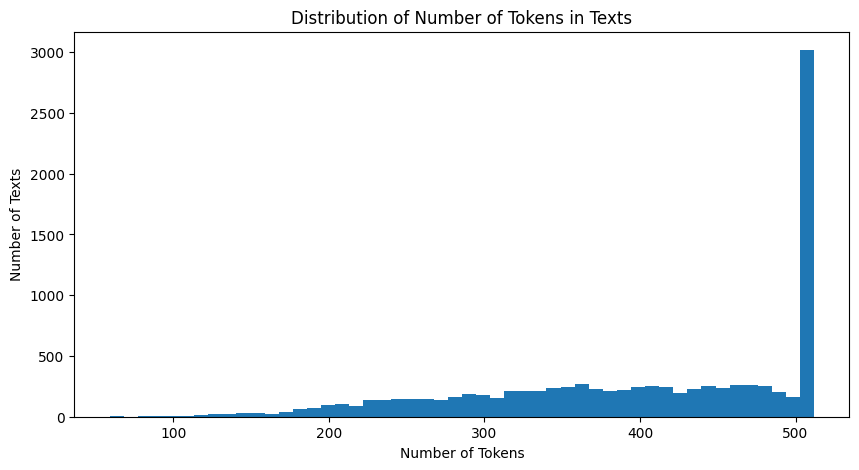

Maximum number of tokens in a text: 512
95th percentile of number of tokens in a text: 512.0


In [5]:
# Initializing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the text and calculating the number of tokens in each text
df['num_tokens'] = df['text'].apply(lambda x: len(tokenizer.encode(x, truncation=True)))

plt.figure(figsize=(10, 5))
plt.hist(df['num_tokens'], bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Texts')
plt.title('Distribution of Number of Tokens in Texts')
plt.show()

print(f"Maximum number of tokens in a text: {df['num_tokens'].max()}")
print(f"95th percentile of number of tokens in a text: {df['num_tokens'].quantile(0.95)}")

From this histogram, it is evident that the vast majority of essays are around 512 tokens in length. The reason for such a massive spike around this value is most likely due to the maximum number of tokens allowed with the BERT tokenizer, which is 512. So, many of the essays were longer than 512 tokens, but they were truncated to 512 tokens. This should be fine, and means that the training of the model will be more efficient than if we used other tokenizers and more tokens.

Here's an example of how the BERT tokenizer works:

In [6]:
original_sentence = "Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!"
tokens = tokenizer.tokenize(original_sentence)
input_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original sentence:\n{original_sentence}')
print(f'Tokens:\n{tokens}')
print(f'Input IDs:\n{input_ids}')

Original sentence:
Hello, I'm Taavi. I love AI and I'd love to work at OpenAI or Google Deepmind!
Tokens:
['hello', ',', 'i', "'", 'm', 'ta', '##avi', '.', 'i', 'love', 'ai', 'and', 'i', "'", 'd', 'love', 'to', 'work', 'at', 'open', '##ai', 'or', 'google', 'deep', '##mind', '!']
Input IDs:
[7592, 1010, 1045, 1005, 1049, 11937, 18891, 1012, 1045, 2293, 9932, 1998, 1045, 1005, 1040, 2293, 2000, 2147, 2012, 2330, 4886, 2030, 8224, 2784, 23356, 999]


As we can see, the tokenizer splits the sentence into tokens, and some words have been split into smaller parts, like Taavi into "ta" and "##avi", OpenAI into "open" and "##ai", and Deepmind into "deep" and "##mind".

This is because BERT uses a WordPiece tokenizer that splits words into smaller parts if the word is not in its vocabulary.

The resulting input ids are usually converted to tensors for use in models, as I have done in the next section, with the `TextDataset` class.

### Creating The Dataset

Below, I have defined a custom `TextDataset` class, which inherits from PyTorch's `Dataset` class. An instance of the object takes in the following parameters:

- `dataframe` - The dataframe from which the dataset should be created
- `tokenizer` - The tokenizer to be used
- `max_len` - The maximum length of each data input

In [7]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe.generated
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Encoding and truncating/padding to max_len
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']

        # Calculating the length of the sequence before padding
        text_length = len([token for token in ids if token != self.tokenizer.pad_token_id])

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float),
            'text_lengths': torch.tensor(text_length, dtype=torch.long)
        }

`__getitem__` will be called with each index in the dataframe later on by the data loaders. It takes in an index, and uses that index to access the specified row in the dataframe. The `text` (essay) is then extracted, encoded to `ids` and truncated/padded to `max_len`. This ensures that each input to the model has the same length. The `text_length`, which is the length of the text without padding, is required by the model in the forward pass. Everything is converted to tensors before being returned.

The following dictionary is returned for each call:

- `ids` - The text (essay) as a tensor
- `targets` - The target (human or AI, 0 or 1) as a tensor
- `text_lengths` - The length of the essay in tokens, excluding padding

Below, I've set the `max_len` variable to 512, as that was the number of tokens for most essays in the data. Essays longer than this will be truncated to 512 tokens, and essays longer than this will be padded to 512, ensuring that all sequences passed to the model are of the same length.

In [8]:
max_len = 512

# Create the Dataset
dataset = TextDataset(df, tokenizer, max_len)

I wrote a function to create the data loaders, so that train/test/validation splits can be easily modified later on. I currently have them set to 80% for training, 10% for validation and 10% for testing, along with a batch size of 128.

The function returns data loaders for each of these using the specified parameters, taking in a `TextDataset` object created earlier.

In [9]:
def create_data_loaders(dataset, train_prop=0.8, val_prop=0.1, test_prop=0.1, batch_size=128):
    train_len = int(train_prop * len(dataset))
    val_len = int(val_prop * len(dataset))
    test_len = int(test_prop * len(dataset))

    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [10]:
train_loader, val_loader, test_loader = create_data_loaders(dataset)

### Building The Model

This part was rather tricky, as PyTorch requires you to implement the `forward` function yourself.

The class has the following components:

1. **Embedding Layer (`self.embedding`)**: This layer transforms the input words (represented as numbers) into dense vectors of fixed size. The `vocab_size` parameter is the number of unique words in the vocabulary, and `embedding_dim` is the size of the embedding vectors.

2. **LSTM Layer (`self.lstm`)**: This is the main component of the model. It's a type of recurrent neural network (RNN) that can learn long-term dependencies between words in the text. The `input_size` is the size of the input to each LSTM cell (which is the size of the embedding), and `dimension` is the size of the hidden state and cell state of the LSTM.

3. **Dropout Layer (`self.drop`)**: This layer randomly sets a fraction `p` of the input units to 0 at each update during training time, which helps prevent overfitting.

4. **Linear Layer (`self.fc`)**: This layer is a linear transformation (y = Ax + b) that is applied to the output of the LSTM layer. It reduces the dimension from `dimension` to 1. The output of this layer is then passed through a sigmoid function to output a probability.

In the `forward` method, the input text is passed through each of these layers in turn. The LSTM layer uses packed sequences for efficiency (`pack_padded_sequence`), and the output from the LSTM is unpacked and the final hidden state is extracted and passed through the dropout and linear layers. The output is then squeezed to remove any extra dimensions and a sigmoid function is applied to get the final output probability.

In [11]:
class LSTMClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, dimension):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dimension = dimension

        # LSTM layer of size dimension, with one layer
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)

        # Dropout layer
        self.drop = nn.Dropout(p=0.5)

        # Fully connected layer for outputting the final result
        self.fc = nn.Linear(dimension, 1)

    def forward(self, text, text_len):
        # Turning words into embeddings
        text_emb = self.embedding(text)

        # Packing the sequence of embeddings
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True)

        # Processing sequence with LSTM layer
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        # Extracting the output of the final LSTM unit
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]

        # Applying dropout for regularization
        text_fea = self.drop(out_forward)

        # Passing through fully connected layer
        text_fea = self.fc(text_fea)

        # Removing unnecessary dimension
        text_fea = torch.squeeze(text_fea, 1)

        # Applying sigmoid activation function to get output in range 0-1
        text_out = torch.sigmoid(text_fea)

        return text_out

Creating the mode, with a `vocab_size` equal to the length of the tokenizer's vocabulary, a `dimension` of 32, and an `embedding_dim` of 100.

1. `embedding_dim` of 100: This refers to the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or 256, etc. This is the size of the dense vector that each word will be transformed into. In other words, each input word will be represented by a vector of size 100.

2. `dimension` of 32: This is the dimensionality of the output space of LSTM layer. In other words, it is the number of nodes in the hidden layer of the LSTM. This means that the LSTM will output vectors of size 32. This is often called the number of "hidden units" or "LSTM units". This is a hyperparameter you can tune, and different values can result in different model performance.

3. `vocab_size` of `len(tokenizer.vocab)`: This is a parameter that specifies the number of unique words in the vocabulary. In the context of this model, it's used to define the size of the embedding layer, which will learn a vector representation for each word in the vocabulary.

    `len(tokenizer.vocab)` gives the number of unique words that the tokenizer can recognize. By setting `vocab_size` to that, we're ensuring that the embedding layer can learn a unique vector representation for each word in the tokenizer's vocabulary.

In [12]:
# Defining model hyperparameters
vocab_size = len(tokenizer.vocab)
dimension = 32
embedding_dim = 100

print(f'Vocab size: {vocab_size}')
model = LSTMClassifier(vocab_size, embedding_dim, dimension)

Vocab size: 30522


Taking a look at the model summary. Unfortunately, we can't do it in a nice visual way as we can with Tensorflow, but we can still inspect the architecture:

In [13]:
def print_model_summary(model):
    print('Model Summary:')
    print('--------------------')
    total_params = 0
    for name, parameter in model.named_parameters():
        param = parameter.numel()
        total_params+=param
        print(f'{name}\t{str(list(parameter.shape))}\t{param}')
    print('--------------------')
    print(f'Total Params:{total_params}')

print_model_summary(model)

Model Summary:
--------------------
embedding.weight	[30522, 100]	3052200
lstm.weight_ih_l0	[128, 100]	12800
lstm.weight_hh_l0	[128, 32]	4096
lstm.bias_ih_l0	[128]	128
lstm.bias_hh_l0	[128]	128
fc.weight	[1, 32]	32
fc.bias	[1]	1
--------------------
Total Params:3069385


Something important to note here is that in PyTorch's LSTM implementation, an LSTM layer's weights and biases are organized into "gates". Each LSTM unit has 4 gates (input, forget, cell and output), so the total number of weight and bias parameters for each LSTM unit is 4 times the number of units https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html.

So, for this model:

- `lstm.weight_ih_l0 [128, 100]` and `lstm.bias_ih_l0 [128]` are the weights and biases for the input-to-hidden connections. The first dimension is 128 because there are 32 LSTM units * 4 gates per unit

- `lstm.weight_hh_l0 [128, 32]` and `lstm.bias_hh_l0 [128]` are the weights and biases for the hidden-to-hidden connections. Here as well, the first dimension is 128 because there are 32 LSTM units * 4 gates per unit

### Training The Model

PyTorch also requires you to write your own training and testing loops. I decided to organize these into their own functions.

The `train_model` function below takes as parameters `epochs`, `train_loader`, `val_loader`, `model`, `criterion`, `optimizer` and `device`.

- `epochs` - The number of training iterations
- `train_loader` - The data loader with the training data
- `val_loader` - The data loader with the validation data
- `model` - The model being trained
- `criterion` - The loss function to use
- `optimizer` - The optimizer to use
- `device` - The device on which to train on, ideally GPU but CPU if that's not available

The function keeps track of the losses during training, both train and validation. Additionally, the validation accuracies are also tracked.

In [18]:
# Train function

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Performing training on all batches for an epoch
        model.train() # Setting model to training mode
        # Initializing progress bar
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch')

        # Initializing loss for this epoch
        epoch_train_loss = 0
        for batch in train_progress_bar:
            # Zeroing the gradients
            optimizer.zero_grad()

            # Sorting the lengths of text in descending order and getting the sorted indices
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            # Using the sorted indices to rearrange the ids and targets
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            # Moving ids and targets to the specified device
            # PyTorch expects the lengths tensor to be on the CPU, so we won't move that
            ids = ids.to(device)
            targets = targets.to(device)

            # Forward pass: computing predictions y by passing x (ids and text lengths) to the model
            predictions = model(ids, text_lengths)
            # Computing loss with the specified criterion
            loss = criterion(predictions, targets)

            # Backward pass: computing gradient of the loss with respect to model parameters
            loss.backward()
            # Performing a single optimization step (parameter update)
            optimizer.step()

            # Updating training loss for epoch
            epoch_train_loss += loss.item()
            # Updating progress bar
            train_progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Appending average training loss for epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Performing validation at the end of each epoch
        model.eval() # Setting the model to evaluation mode
        with torch.no_grad(): # No gradient during validation. The rest is very similar to training
            total_loss, total_correct, total_labels = 0, 0, 0
            for batch in val_loader:
                text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
                ids = batch['ids'][sorted_idx]
                targets = batch['targets'][sorted_idx]

                ids = ids.to(device)
                targets = targets.to(device)

                predictions = model(ids, text_lengths)
                loss = criterion(predictions, targets)

                total_loss += loss.item() * ids.size(0)
                total_correct += (predictions.round() == targets).sum().item()
                total_labels += ids.size(0)

            avg_loss = total_loss / total_labels
            avg_acc = total_correct / total_labels

            val_losses.append(avg_loss)
            val_accuracies.append(avg_acc)

            print(f'Validation Loss: {avg_loss:.3f}, Validation Accuracy: {avg_acc:.3f}')

    return train_losses, val_losses, val_accuracies

I don't have a GPU on my own laptop, but this cell will set the device to GPU if it's available.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Here, I set `criterion` to `nn.BCELoss()` and `optimizer` to Adam.

- `nn.BCELoss` - Binary Cross Entropy Loss, commonly used for binary classification problems such as this one. It measures the error between the model's predictions and the true values, which are expected to be 0 for the negative class or 1 for the positive class

- `torch.optim.Adam` - Adaptive Moment Estimation, a popular choice for many deep learning models. It adapts the learning rate for each weight in the model individually, based on estimates of first and second moments of the gradients

An `epoch` length of 10 works quite well for this dataset, and doesn't take too long.

In [20]:
# Defining loss function
criterion = nn.BCELoss()

# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Moving the model and loss function to same device
model = model.to(device)
criterion = criterion.to(device)

# Defining number of epochs
epochs = 10

In [21]:
train_losses, val_losses, val_accuracies = train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1/10: 100%|██████████| 63/63 [01:24<00:00,  1.34s/batch, training_loss=0.635]


Validation Loss: 0.665, Validation Accuracy: 0.615


Epoch 2/10: 100%|██████████| 63/63 [01:19<00:00,  1.26s/batch, training_loss=0.538]


Validation Loss: 0.525, Validation Accuracy: 0.757


Epoch 3/10: 100%|██████████| 63/63 [01:19<00:00,  1.26s/batch, training_loss=0.418]


Validation Loss: 0.409, Validation Accuracy: 0.850


Epoch 4/10: 100%|██████████| 63/63 [01:18<00:00,  1.25s/batch, training_loss=0.375]


Validation Loss: 0.277, Validation Accuracy: 0.909


Epoch 5/10: 100%|██████████| 63/63 [01:18<00:00,  1.25s/batch, training_loss=0.209]


Validation Loss: 0.243, Validation Accuracy: 0.925


Epoch 6/10: 100%|██████████| 63/63 [01:19<00:00,  1.26s/batch, training_loss=0.361]


Validation Loss: 0.261, Validation Accuracy: 0.922


Epoch 7/10: 100%|██████████| 63/63 [01:19<00:00,  1.26s/batch, training_loss=0.256]


Validation Loss: 0.247, Validation Accuracy: 0.921


Epoch 8/10: 100%|██████████| 63/63 [01:19<00:00,  1.26s/batch, training_loss=0.211]


Validation Loss: 0.249, Validation Accuracy: 0.922


Epoch 9/10: 100%|██████████| 63/63 [02:04<00:00,  1.97s/batch, training_loss=0.203]


Validation Loss: 0.189, Validation Accuracy: 0.942


Epoch 10/10: 100%|██████████| 63/63 [01:47<00:00,  1.70s/batch, training_loss=0.328]


Validation Loss: 0.254, Validation Accuracy: 0.908


The cells below are used for saving the model in my Google Drive when using Colab, and saving the training metrics:

In [24]:
# # Saving in Colab
# path = '/content/drive/My Drive/AI classification/model_LSTM.pth'
# torch.save(model.state_dict(), path)

In [23]:
# with open('/content/drive/My Drive/AI classification/train_val_metrics.pkl', 'wb') as f:
#     pickle.dump((train_losses, val_losses, val_accuracies), f)

Loading saved metrics:

In [ ]:
# with open('/content/drive/My Drive/AI classification/train_val_metrics.pkl', 'rb') as f:
#     train_losses, val_losses, val_accuracies = pickle.load(f)

### Visualizing The Training

Using the values returned by the `train_model` function, we can plot the training loss, validation loss, and validation accuracy over time:

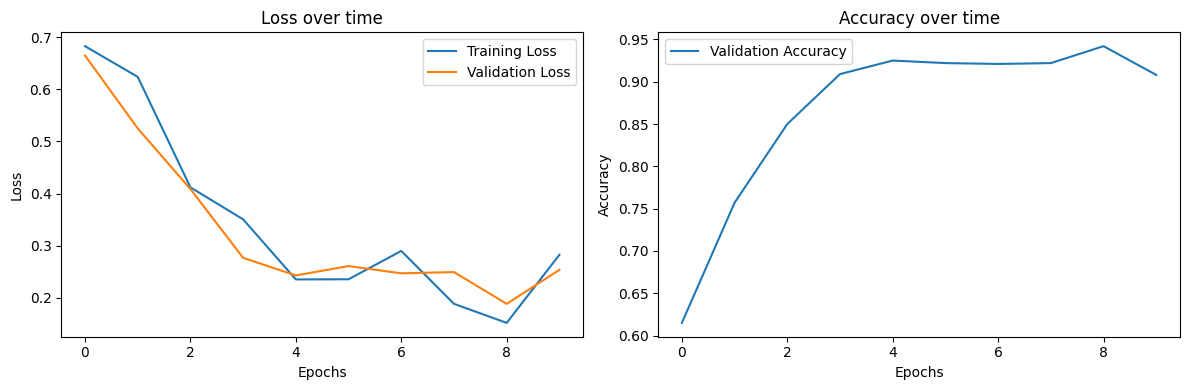

In [25]:
plt.figure(figsize=(12, 4))

# Training and validation loss over epochs
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Validation accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluating the model

Loading a saved model, with a new `model` created with the exact same specifications as the one the saved model was trained on.

In [ ]:
# path = 'model.pth'
# model = LSTMClassifier(len(tokenizer.vocab), 100, 32)
# model.load_state_dict(torch.load(path))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

The following function is for evaluating a trained model based on test data in `test_loader`. It takes as parameters `test_loader`, `model`, `criterion` and `device`.

- `test_loader` - The data loader with the test data
- `model` - The model being evaluated
- `criterion` - The loss function to use (should be the same as during training)
- `device` - The device on which to train on, ideally GPU but CPU if that's not available

The function is very similar to the validation step in the `train_model` function, so no need to add a lot of comments here.

**Note:** I'm using `.round()` to round predictions to the nearest integer, effectively using a threshold of 0.5. This is a common way to make binary predictions when the model's output is a probability. However, in a real world scenario where such technology would be used to detect AI text and possibly investivate students, a higher threshold should be used to avoid false positives.

This would most likely decrease the accuracy of the model on test data, but would ensure that as few people as possible are wrongfully accused.

In [28]:
# Evaluation function

def evaluate_model(test_loader, model, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_labels = 0, 0, 0
        all_predictions = []
        all_targets = []
        for batch in test_loader:
            text_lengths, sorted_idx = batch['text_lengths'].sort(descending=True)
            ids = batch['ids'][sorted_idx]
            targets = batch['targets'][sorted_idx]

            ids = ids.to(device)
            targets = targets.to(device)

            predictions = model(ids, text_lengths)
            loss = criterion(predictions, targets)

            total_loss += loss.item() * ids.size(0)
            total_correct += (predictions.round() == targets).sum().item() # Rounding creates a threshold of 0.5
            total_labels += ids.size(0)

            all_predictions.extend(predictions.round().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

        avg_loss = total_loss / total_labels
        avg_acc = total_correct / total_labels

        print(f'Test Loss: {avg_loss:.3f}, Test Accuracy: {avg_acc:.3f}')

        # Generating a classification report and confusion matrix
        class_report = classification_report(all_targets, all_predictions)
        conf_matrix = confusion_matrix(all_targets, all_predictions)

        print(class_report)

    return avg_loss, avg_acc, conf_matrix

In [29]:
test_loss, test_acc, conf_matrix = evaluate_model(test_loader, model, criterion, device)

Test Loss: 0.259, Test Accuracy: 0.905
              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90       469
         1.0       0.93      0.89      0.91       531

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.90      1000
weighted avg       0.91      0.91      0.91      1000



Taking a look at the confusion matrix:

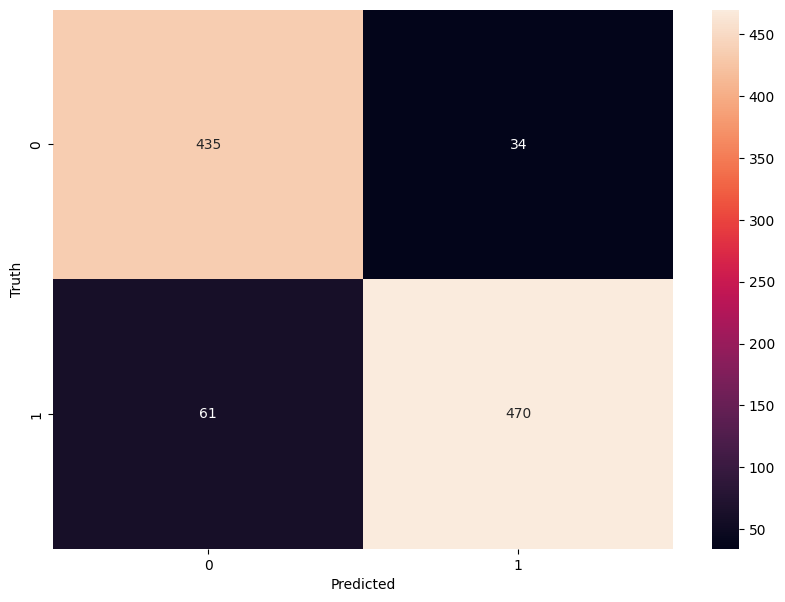

In [30]:
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Acknowledgements

- [LSTM Text Classification Using Pytorch](https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0) - Raymond Cheng
    - An excellent article about the implementation of LSTMs in PyTorch. He implemented a bidirectional model in his article, whereas I implemented a unidirectional one.